In [2]:
import numpy as np
import tensorflow as tf
import pennylane as qml
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

from src.learn import *
from src.quantum_dense_net import QuantumDenseNet

# Prepare data

In [3]:
iris = load_iris()
X = iris.data
y = iris.target

class_n = max(y) + 1
one_hot = np.zeros((y.shape[0], class_n))
one_hot[np.arange(y.size), y] = 1
y = one_hot
# Because there is no alternative of sigmoid in quantum nets
# we will make targets to be a range from -1 to 1 for symmetry
y = y * 2 - 1

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [14]:
mean = np.mean(X_train, axis = 0)
X_train -= mean
X_test -= mean
# Due to the limited size of infinite dimensional hilbert space in simulation we will put all data in a range from -1 to 1
anti_var = np.max(abs(X_train), axis = 0)
X_train /=  anti_var
X_test /=  anti_var

# Set common params

In [15]:
tf.random.set_seed(42)

In [16]:
bs = 4
epochs = 40

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(bs)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(bs)

In [26]:
loss_fn = tf.keras.losses.MeanSquaredError()
opt = tf.keras.optimizers.legacy.Adam(learning_rate = 0.01)

In [18]:
def acc_fn(out, y):
    pred = tf.math.argmax(out, axis = 1)
    one_hot = np.zeros((pred.shape[0], class_n))
    one_hot[np.arange(pred.shape[0]), pred] = 1
    vector = one_hot * 2 - 1
    f = tf.cast(vector == y, tf.float32)
    return float(tf.reduce_mean(f))

# Train classical model for comparison 

In [19]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(4, activation=tf.nn.relu, input_shape=(4,)),
    tf.keras.layers.Dense(3, activation=tf.nn.tanh),
])

In [20]:
tr_r, te_r, acc = learn(model, train_dataset, test_dataset, loss_fn, opt, metric_fn = acc_fn, epochs = epochs)


Start of epoch 0
Train and test losses: 0.7576, 0.8125
Metric: 0.6167

Start of epoch 1
Train and test losses: 0.5843, 0.6216
Metric: 0.8333

Start of epoch 2
Train and test losses: 0.4805, 0.4940
Metric: 0.9167

Start of epoch 3
Train and test losses: 0.3871, 0.3801
Metric: 0.9333

Start of epoch 4
Train and test losses: 0.3076, 0.2875
Metric: 0.9500

Start of epoch 5
Train and test losses: 0.2474, 0.2174
Metric: 0.9833

Start of epoch 6
Train and test losses: 0.2032, 0.1671
Metric: 0.9833

Start of epoch 7
Train and test losses: 0.1705, 0.1307
Metric: 0.9833

Start of epoch 8
Train and test losses: 0.1462, 0.1045
Metric: 1.0000

Start of epoch 9
Train and test losses: 0.1278, 0.0856
Metric: 1.0000

Start of epoch 10
Train and test losses: 0.1139, 0.0718
Metric: 1.0000

Start of epoch 11
Train and test losses: 0.1032, 0.0617
Metric: 1.0000

Start of epoch 12
Train and test losses: 0.0948, 0.0544
Metric: 1.0000

Start of epoch 13
Train and test losses: 0.0883, 0.0489
Metric: 1.0000

S

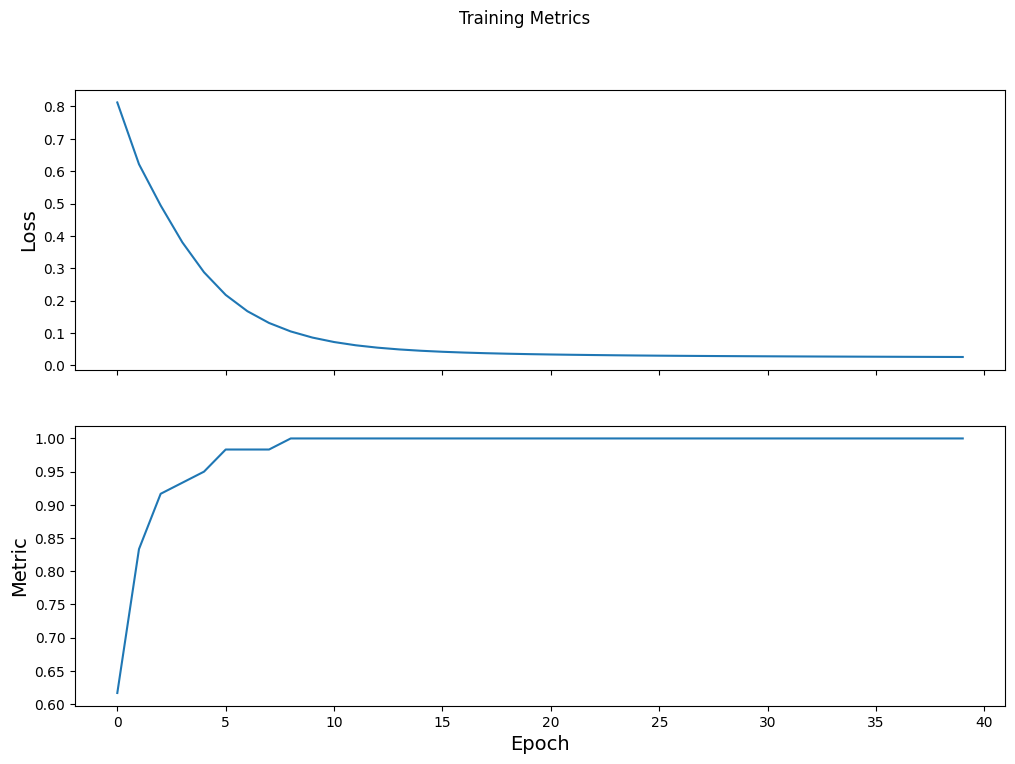

In [21]:
plot(te_r, acc)

# Train quantum model

In [22]:
qml.enable_tape()
cutoff_dim = 9
dev = qml.device('strawberryfields.tf', cutoff_dim = cutoff_dim, wires = 4)
qml.enable_tape()

In [23]:
# it seems that it is not possible to calc qml.state() for fock space right now ...
qml.enable_tape() 

Use Kerr activation on the last layer. This does not guarantee that output will be in some range, but for predication we use argmax so it is not crucial

In [27]:
model = QuantumDenseNet(4, class_n, layers = 2, dev = dev)
tr_r, te_r, acc = learn(model, train_dataset, test_dataset, loss_fn, opt, metric_fn = acc_fn, epochs = epochs, record_trace = False)


Start of epoch 0


Train and test losses: 0.6340, 0.6134
Metric: 0.8333

Start of epoch 1


Train and test losses: 0.3840, 0.3673
Metric: 0.9167

Start of epoch 2


KeyboardInterrupt: 

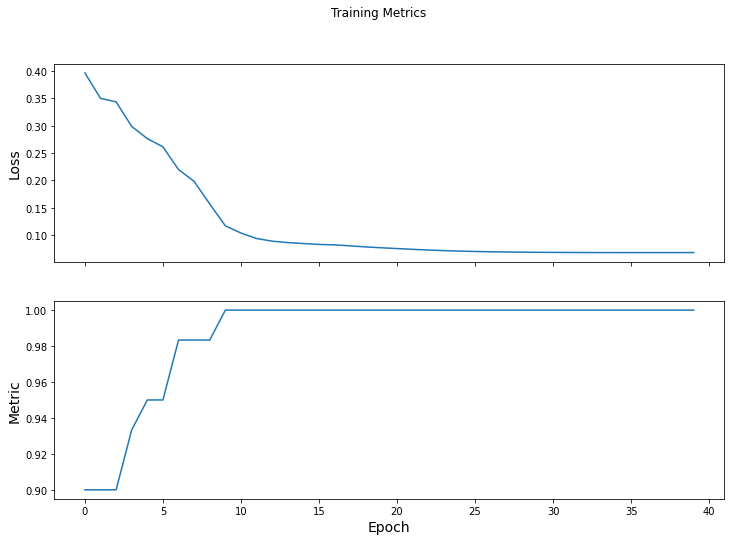

In [15]:
plot(te_r, acc)

Remove the Kerr layer before expval and add activation tanh after.
This will make all outputs to be in range from -1 to 1 as they should be

In [25]:
model = tf.keras.Sequential([
    QuantumDenseNet(4, class_n, layers = 2, last_activation = False, dev = dev),
    tf.keras.layers.Activation('tanh')
])
tr_r, te_r, acc = learn(model, train_dataset, test_dataset, loss_fn, opt, metric_fn = acc_fn, epochs = epochs, record_trace = False)


Start of epoch 0


KeyError: 'The optimizer cannot recognize variable quantum_dense_net_1/Variable:0. This usually means you are trying to call the optimizer to update different parts of the model separately. Please call `optimizer.build(variables)` with the full list of trainable variables before the training loop or use legacy optimizer `tf.keras.optimizers.legacy.Adam.'

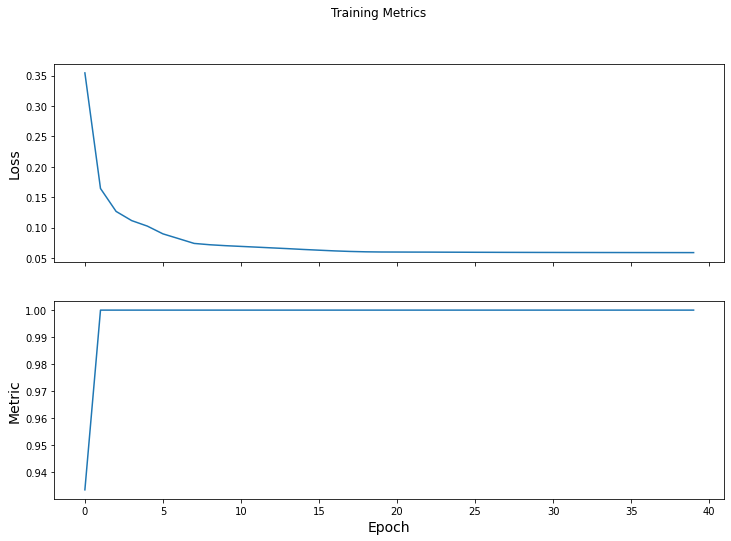

In [17]:
plot(te_r, acc)

Kerr activation followed by tanh for output range consistency

In [18]:
model = tf.keras.Sequential([
    QuantumDenseNet(4, class_n, layers = 2, dev = dev),
    tf.keras.layers.Activation('tanh')
])
tr_r, te_r, acc = learn(model, train_dataset, test_dataset, loss_fn, opt, metric_fn = acc_fn, epochs = epochs, record_trace = False)


Start of epoch 0
Train and test losses: 0.4817, 0.5327
Metric: 0.8167

Start of epoch 1
Train and test losses: 0.3355, 0.3257
Metric: 0.9167

Start of epoch 2
Train and test losses: 0.2842, 0.2682
Metric: 0.9333

Start of epoch 3
Train and test losses: 0.2551, 0.2453
Metric: 0.9500

Start of epoch 4
Train and test losses: 0.1687, 0.1439
Metric: 0.9833

Start of epoch 5
Train and test losses: 0.1426, 0.1095
Metric: 1.0000

Start of epoch 6
Train and test losses: 0.1335, 0.0975
Metric: 1.0000

Start of epoch 7
Train and test losses: 0.1286, 0.0912
Metric: 1.0000

Start of epoch 8
Train and test losses: 0.1238, 0.0857
Metric: 1.0000

Start of epoch 9
Train and test losses: 0.1212, 0.0803
Metric: 1.0000

Start of epoch 10
Train and test losses: 0.1213, 0.0776
Metric: 1.0000

Start of epoch 11
Train and test losses: 0.1215, 0.0766
Metric: 1.0000

Start of epoch 12
Train and test losses: 0.1198, 0.0753
Metric: 1.0000

Start of epoch 13
Train and test losses: 0.1182, 0.0741
Metric: 1.0000

S

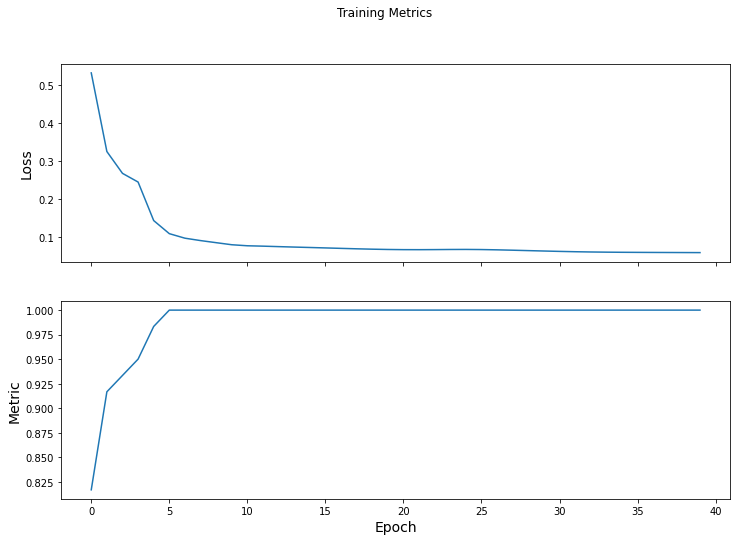

In [19]:
plot(te_r, acc)